In [726]:
import pandas as pd
import numpy as np
from copy import deepcopy


import string
#!pip install nltk
import nltk
nltk.download('punkt')
from nltk import word_tokenize, Counter
from nltk.corpus import stopwords
import itertools
import spacy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhinavsharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [727]:
df = pd.read_csv('marijuana.csv')
df_true = deepcopy(df)
df_dem = pd.read_csv('tweetsDemocrat.csv')
#df = deepcopy(df_dem)
num_tweets = df.shape[0]
print(df.columns)
df.head()

Index(['Unnamed: 0', 'Message', 'Tweet Favorite Count', 'Retweet Count',
       'Created At', 'Username', 'Likes', 'User Description', 'Following',
       'Followers'],
      dtype='object')


,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers
0,0,Medical #cannabis sales in #Arkansas surpassed...,1,0,2022-02-25 22:01:52+00:00,ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643
1,1,RT @KeepfitKingdom: NO SLEEP? Then CBD or Krat...,0,1,2022-02-25 22:01:11+00:00,AlanRiseboro7,139,NaN,241,23
2,2,What are 1-4 issues you want to fix in South D...,0,0,2022-02-25 22:01:07+00:00,JodellWb,46712,Dog lover,1458,327
3,3,RT @LePro_1: ☮️ Make Art Not War! ☮️🕊️🌿\n\nCry...,0,33,2022-02-25 22:01:01+00:00,Ikky_Arts,5929,🚀 Fractal Multiverse Collection\n👉 100 Unique ...,1313,1591
4,4,The Pennsylvania Department of Agriculture is ...,0,0,2022-02-25 22:00:59+00:00,JuanLaceyFCB,0,Farms Close By - CEO,3,2


In [728]:
#function to get username in twitter format

def add_a(row):
    return '@'+row['Username']

In [729]:
#function to find User_B

import re

def find_b(row):
    tweet = row['Message']
    user = re.findall('\@[^\s\:]+',tweet)
    if user:
        return user
    else:
        return [row['Username']]

In [730]:
df['Username'] = df.apply(add_a, axis = 1)
df['User_B'] = df.apply(find_b, axis = 1)

In [731]:
f = lambda x: 'User_{}'.format(x + 1)
df_2 = pd.DataFrame(
    df.User_B.values.tolist(),
    df.index, dtype=object
).fillna('').rename(columns=f)

df_2["User_A"] = df["Username"]
df_2["Message"] = df["Message"]

In [732]:
l = len(df_2.columns)
new_list = []
for index, row in df_2.iterrows():
    for i in range(l-2):
        new_list.append([row['User_A'],row['User_{}'.format(i + 1)],row['Message']])

In [733]:
df_3 = pd.DataFrame(new_list, columns = {'User_A','User_B','Message'})
df_3 = df_3.replace(r'^\s*$', np.nan, regex=True)
df_3 = df_3.dropna()
df_3 = df_3.rename(columns = {'User_A':'User_B', "User_B":'User_A'})
df_3.head()

,User_B,User_A,Message
0,@ganjapreneur,@ganjapreneur,Medical #cannabis sales in #Arkansas surpassed...
9,@AlanRiseboro7,@KeepfitKingdom,RT @KeepfitKingdom: NO SLEEP? Then CBD or Krat...
18,@JodellWb,@JodellWb,What are 1-4 issues you want to fix in South D...
27,@Ikky_Arts,@LePro_1,RT @LePro_1: ☮️ Make Art Not War! ☮️🕊️🌿\n\nCry...
28,@Ikky_Arts,@OpenSea,RT @LePro_1: ☮️ Make Art Not War! ☮️🕊️🌿\n\nCry...


In [734]:
df_3['User_B'] = df_3['User_B'].apply(''.join)
df = df_3
df.shape

(6198, 3)

In [735]:
#function to find tweet, retweet, mention, or reply

def extract_type(row):
    if row['User_B'] == row['User_A']:
        return 'Tweet'
    elif row['Message'][0:2] == 'RT':
        return 'Retweet'
    elif row['Message'][0] == '@':
        return 'Reply'
    else:
        return 'Mention'

In [736]:
df['Type'] = df.apply(extract_type, axis = 1)

In [737]:
final = df[['User_A', 'User_B', 'Type']]

final.head()

,User_A,User_B,Type
0,@ganjapreneur,@ganjapreneur,Tweet
9,@KeepfitKingdom,@AlanRiseboro7,Retweet
18,@JodellWb,@JodellWb,Tweet
27,@LePro_1,@Ikky_Arts,Retweet
28,@OpenSea,@Ikky_Arts,Retweet


In [738]:
#final.to_csv("network.csv")

## Getting key words in the tweets

In [739]:
stop_ls = ['rt']
stop_ls1 = list(df['User_A'].apply(lambda x : re.sub(r"\B@", "", x).lower()))
stop_ls2 = list(df['User_B'].apply(lambda x : re.sub(r"\B@", "", x).lower()))

In [740]:
#Helper functions ---

# function to lemmatize all words in captions
def lemmatization(text):
    text = nlp(text)
    text_lemma = [word.lemma_ for word in text]
    return " ".join(text_lemma)

# function to clean caption obtained from scrapper
def wrangle(text):
    text = text.replace('“', '"').replace('”','"').replace('’', "'")
    printable = set(string.printable)
    text = ''.join(filter(lambda x: x in printable, text))
   
    return text

# function to remove stop words and punctuations from the list of caption words
def remove_stopwords(lst):
    return [word for word in lst if 
            ( (word not in stopwords.words()) &
            (word not in list(string.punctuation)) &
            (word not in list(string.digits)) &
             (word not in stop_ls) &
             (word not in stop_ls1) &
             (word not in stop_ls2) 
            
            
            )]

# applying the cleaning functions
def caption_cleaning(data):
    # subsetting captions only
    captions = data[['caption']]
    captions['caption'] = captions['caption'].astype(str).str.strip()
    captions['caption'] = captions['caption'].map(lambda s: wrangle(s))
    #captions['caption_lemma'] = captions['caption'].map(lemmatization)

    # creating caption list
    captions['caption_list'] = captions['caption'].map(
        lambda row: word_tokenize(row.lower()))
    
    # removing stop words and punctuation
    captions['caption_list'] = captions['caption_list'].map(lambda row: remove_stopwords(row))
    
    return captions

# get tf dataframe
def tf(col):
    # creating tf-idf vector
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(col.values)
    columns = vectorizer.get_feature_names()

    # creating tf idf df
    tf_idf_df = pd.DataFrame(X.toarray(), columns=columns)
    
    return tf_idf_df

# get tf idf dataframe
def tf_idf(col):
    # creating tf-idf vector
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(col.values)
    columns = vectorizer.get_feature_names()

    # creating tf idf df
    tf_idf_df = pd.DataFrame(X.toarray(), columns=columns)
    
    return tf_idf_df

# creating tf-idf vectors
def caption_tf_idf(captions, idf=True):
    # creating a list of caption words
    caption_words_list = []
    for l in list(captions['caption_list'].values):
        caption_words_list = caption_words_list + l

    # removing duplicates 
    caption_words_list = list(set(caption_words_list))

    # removing words with length <= 2
    caption_words_list = [w for w in caption_words_list if ((len(w) > 2) and (w != 'rt'))]

    # converting the text to list
    captions['caption_cleaned'] = captions['caption_list'].map(lambda lst: ' '.join(lst))
    
    # get tf idf vec
    if idf:
        caption_tf_idf = tf_idf(captions['caption_cleaned'])
    else:
        caption_tf_idf = tf(captions['caption_cleaned'])
    caption_words_list = list(set(caption_words_list).intersection(set(caption_tf_idf.columns)))
    caption_tf_idf = caption_tf_idf[caption_words_list]
    
    return caption_tf_idf


In [741]:
#Check for multiple connections
summ = df.groupby(['User_A'])['Message'].agg(['nunique'])
repeat_users = list(summ[summ['nunique']>30].index)

In [742]:
df_sub[df_sub['User_A'].isin(repeat_users)].index

Int64Index([  360,   613,   615,   631,   632,   640,   641,   658,   659,
              891,
            ...
            43632, 43786, 43787, 43803, 43805, 44065, 44172, 44173, 44298,
            44973],
           dtype='int64', length=532)

In [743]:
df_sub = df[(df['User_B'] != df['User_A'])]
df_sub = df_sub[df_sub['User_A'].isin(repeat_users)]
df_sub.rename(columns={'Message':'caption'},inplace=True)
df_sub = df_sub.head(8000)
df_sub.shape

(532, 4)

In [744]:
df_sub.columns

Index(['User_B', 'User_A', 'caption', 'Type'], dtype='object')

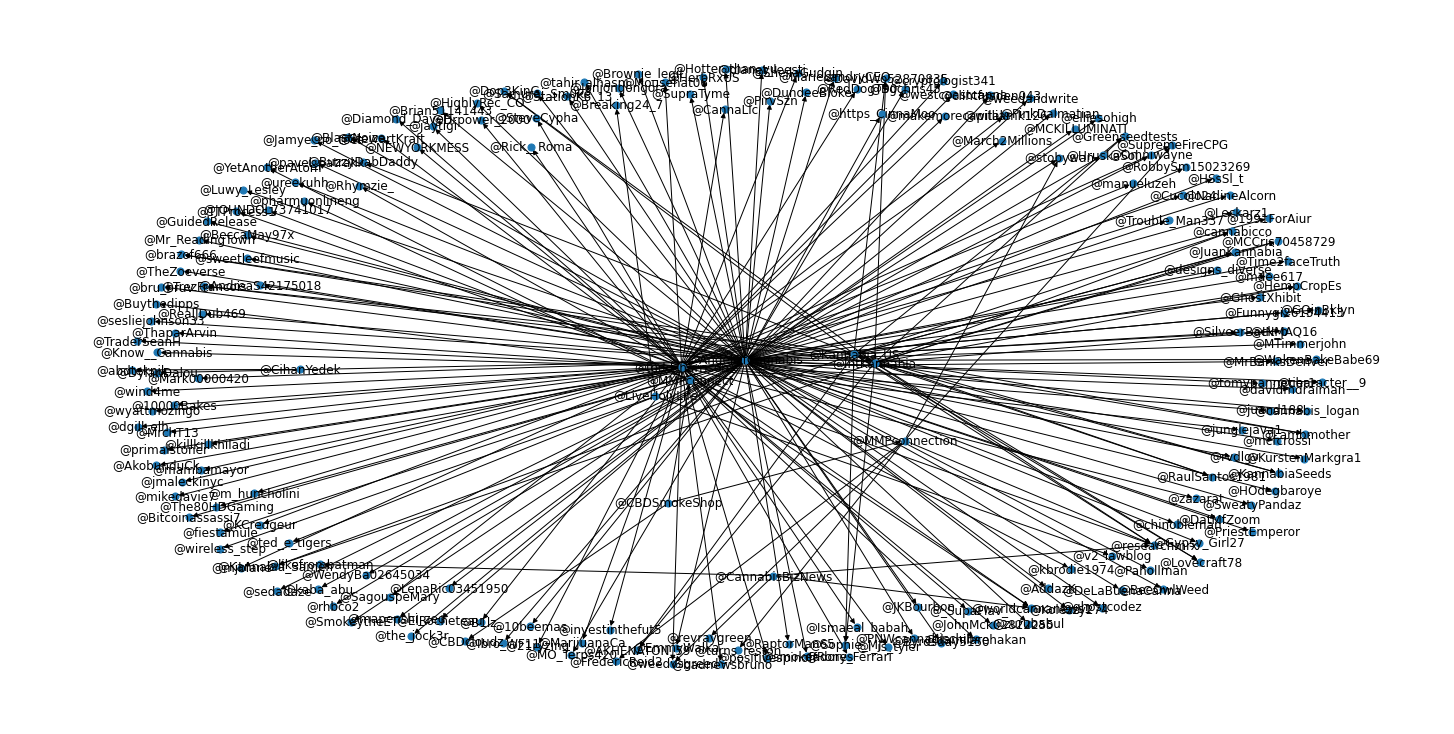

In [745]:
#draw network graph
final_sub = df_sub[['User_A', 'User_B', 'Type']]
final_sub['nodes'] = final_sub[['User_A', 'User_B']].apply(tuple, axis=1)
graph = nx.DiGraph()  
graph.add_edges_from(final_sub['nodes'].sample(500))


plt.figure(figsize = (20, 10))

nx.draw(graph, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

In [746]:
#Takes time
captions = caption_cleaning(df_sub)

KeyboardInterrupt: 

In [747]:
#captions.to_csv('captions.csv')
captions = pd.read_csv('captions.csv')
captions

,Unnamed: 0,caption,caption_list
0,27,RT @LePro_1: Make Art Not War! \n\nCrypto Can...,"['make', 'art', 'crypto', 'cannabis', 'art', '..."
1,28,RT @LePro_1: Make Art Not War! \n\nCrypto Can...,"['make', 'art', 'crypto', 'cannabis', 'art', '..."
2,117,"""For too long, our courts haven't looked like ...","['``', 'long', 'courts', ""n't"", 'looked', 'lik..."
3,309,RT @ricktroche333: If you haven't heard now yo...,"[""n't"", 'heard', 'secretseshnfts', 'secret', '..."
4,360,RT @AngelOfCannabis: Stop right there! #Stoner...,"['stop', 'right', 'stonerfam', 'smokeweed', 'c..."
...,...,...,...
1335,44811,RT @kariss_step28: \nSnap: stephens_step28\nTl...,"['snap', 'stephens_step28', 'tlgram', 'paris',..."
1336,44874,RT @kariss_step28: Snap: stephens_step28\n#par...,"['snap', 'stephens_step28', 'paris', 'citation..."
1337,44892,RT @kariss_step28: Snap: stephens_step28\n#par...,"['snap', 'stephens_step28', 'paris', 'citation..."
1338,44901,RT @kariss_step28: Snap: stephens_step28\n#par...,"['snap', 'stephens_step28', 'paris', 'citation..."


In [748]:
corpus = [y for x in captions['caption_list'] for y in x.strip('[]').split('\', \'')]

In [749]:
corpus_nopunc = [re.sub(r'[^\w\s]','',x) for x in corpus]
corpus_nopunc = list(filter(None, corpus_nopunc))
from collections import Counter
Counter = Counter(corpus_nopunc)
most_occur = Counter.most_common(50)
print(most_occur)

[('https', 688), ('cannabis', 389), ('gracias', 226), ('kannabista', 209), ('art', 193), ('cannabiscommunity', 160), ('ig', 153), ('amigo', 151), ('stonerfam', 122), ('cbd', 118), ('dream', 116), ('smokeweed', 114), ('thanks', 105), ('kannabist', 105), ('crypto', 98), ('make', 97), ('11', 94), ('collection', 93), ('handdrawn', 93), ('illustrations', 87), ('marijuana', 87), ('friend', 81), ('world', 81), ('finance', 80), ('big', 77), ('yidiots', 76), ('russians', 76), ('colonized', 76), ('power', 75), ('medicine', 74), ('media', 74), ('band', 72), ('reggae', 66), ('tcolvk05y3rtb', 65), ('tcogoqiopn5xc', 65), ('flowers', 63), ('academia', 63), ('jamaica', 62), ('hhc', 58), ('amiga', 57), ('cookies', 57), ('haze', 56), ('legal', 52), ('sativa', 50), ('thc', 50), ('swiss', 47), ('auto', 45), ('snap', 43), ('stephens_step28', 43), ('paris', 43)]


In [750]:
#captions[captions['Unnamed: 0'].isin(df_sub[df_sub['User_A'].isin(repeat_users)].index)]
captions.set_index('Unnamed: 0',inplace=True)

In [751]:
captions_summary = captions.merge(df,how='left',left_index=True, right_index=True)
captions_summary = captions_summary[captions_summary['User_A'].isin(repeat_users)]
captions_summary

,caption,caption_list,User_B,User_A,Message,Type
Unnamed: 0,,,,,,
360,RT @AngelOfCannabis: Stop right there! #Stoner...,"['stop', 'right', 'stonerfam', 'smokeweed', 'c...",@DeLaBuenaCanna,@AngelOfCannabis,RT @AngelOfCannabis: Stop right there! #Stoner...,Retweet
613,RT @KannabiaSeeds: LA BLANCA by #KannabiaSeed...,"['blanca', 'gracias', 'amiga', 'kannabista']",@Lambmother,@IntKannabia,RT @KannabiaSeeds: 📷 LA BLANCA by #KannabiaSee...,Retweet
615,RT @KannabiaSeeds: LA BLANCA by #KannabiaSeed...,"['blanca', 'gracias', 'amiga', 'kannabista']",@Lambmother,@Kannabia_US,RT @KannabiaSeeds: 📷 LA BLANCA by #KannabiaSee...,Retweet
631,RT @KannabiaSeeds: GNOMO AUTO by #KannabiaSe...,"['gnomo', 'auto', 'gracias', 'annimo', 'amigo'...",@Lambmother,@IntKannabia,RT @KannabiaSeeds: 📷 GNOMO AUTO 🌻 by #Kannabia...,Retweet
632,RT @KannabiaSeeds: GNOMO AUTO by #KannabiaSe...,"['gnomo', 'auto', 'gracias', 'annimo', 'amigo'...",@Lambmother,@Kannabia_US,RT @KannabiaSeeds: 📷 GNOMO AUTO 🌻 by #Kannabia...,Retweet
...,...,...,...,...,...,...
44065,SWISS DREAM CBD by #KannabiaSeeds @KannabiaSe...,"['swiss', 'dream', 'cbd', 'thanks', 'ig', 'kan...",@IntKannabia,@Kannabia_US,📷 SWISS DREAM CBD by #KannabiaSeeds🌱 @Kannabia...,Mention
44172,SWISS DREAM CBD by #KannabiaSeeds @IntKannab...,"['swiss', 'dream', 'cbd', 'gracias', 'amigo', ...",@KannabiaSeeds,@IntKannabia,📷 SWISS DREAM CBD by #KannabiaSeeds 🌱 @IntKann...,Mention
44173,SWISS DREAM CBD by #KannabiaSeeds @IntKannab...,"['swiss', 'dream', 'cbd', 'gracias', 'amigo', ...",@KannabiaSeeds,@Kannabia_US,📷 SWISS DREAM CBD by #KannabiaSeeds 🌱 @IntKann...,Mention


In [753]:
captions_summary_df = captions_summary.groupby(['User_A']).agg({'caption_list':'sum','User_B':'nunique','Type':'nunique'})
captions_summary_df

,caption_list,User_B,Type
User_A,,,
@AngelOfCannabis,"['stop', 'right', 'stonerfam', 'smokeweed', 'c...",103,2
@CBDSmokeShop,"['edibles', 'cbdoil', 'prerolls', 'cannabis', ...",3,1
@CannabisBizNews,"['nj', 'legal', 'weed', 'sales', 'could', 'beg...",4,1
@CihanYedek,"['https', '//t.co/lvk05y3rtb', 'https', '//t.c...",1,2
@IntKannabia,"['blanca', 'gracias', 'amiga', 'kannabista']['...",19,2
@Kannabia_US,"['blanca', 'gracias', 'amiga', 'kannabista']['...",20,2
@LiveHolyLife,"['yidiotsasylumisrael', 'prison', 'heterosexua...",3,1
@MMPconnect,"['cannabiscommunity', 'marijuana', 'cannabis',...",4,1
@MMPconnection,"['cannabiscommunity', 'marijuana', 'cannabis',...",6,1


In [756]:
captions_summary_df[captions_summary_df.index == '@AngelOfCannabis']['caption_list']

User_A
@AngelOfCannabis    ['stop', 'right', 'stonerfam', 'smokeweed', 'c...
Name: caption_list, dtype: object

In [618]:
df_wordcloud = WordCloud(background_color='white',max_font_size = 50).generate(corpus_nopunc)
plt.imshow(df_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object

In [289]:
import networkx as nx
import matplotlib.pyplot as plt 

final = pd.read_csv('network.csv')
final['nodes'] = final[['User_A', 'User_B']].apply(tuple, axis=1)

/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


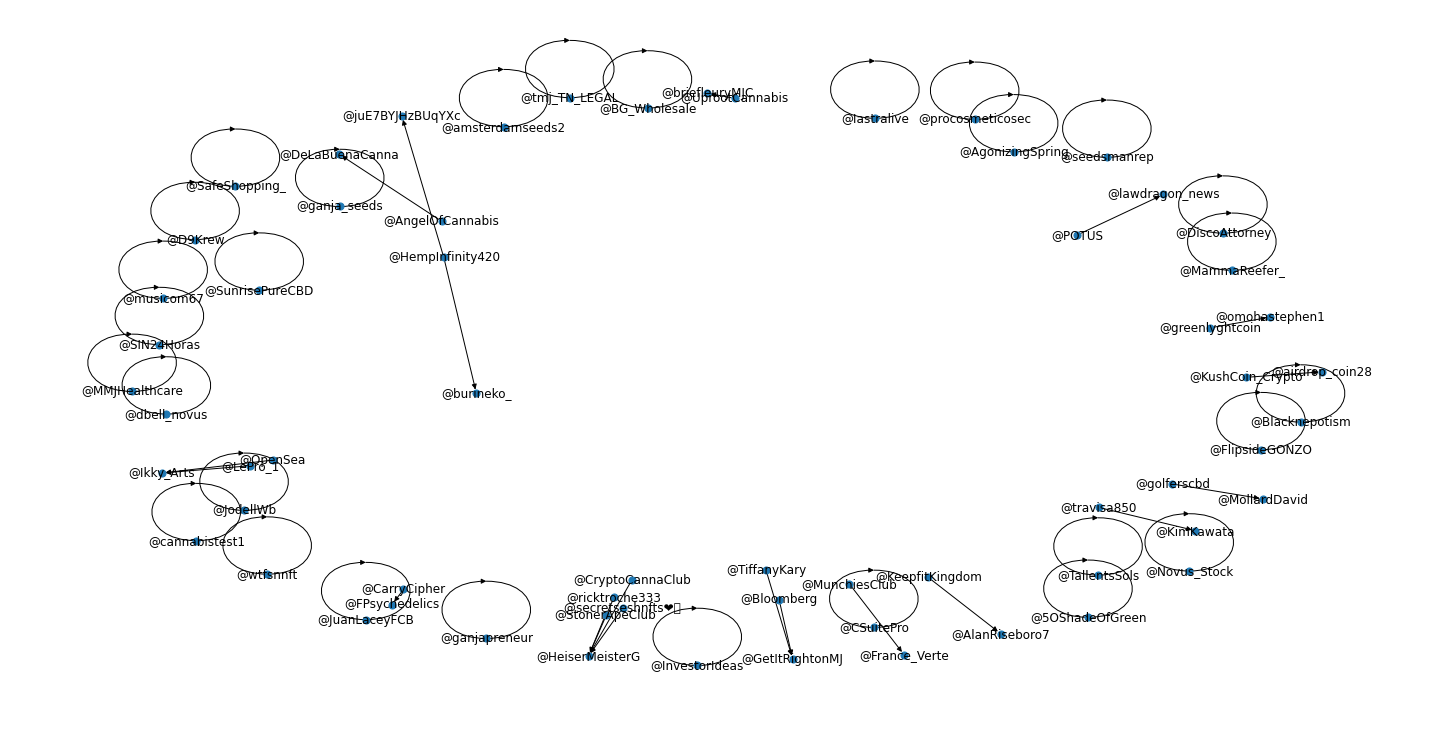

In [290]:
#draw network graph


final_copy = deepcopy(final)
final_copy_sub = final.head(50)

graph = nx.DiGraph()  
graph.add_edges_from(final_copy_sub['nodes'])


plt.figure(figsize = (20, 10))

nx.draw(graph, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


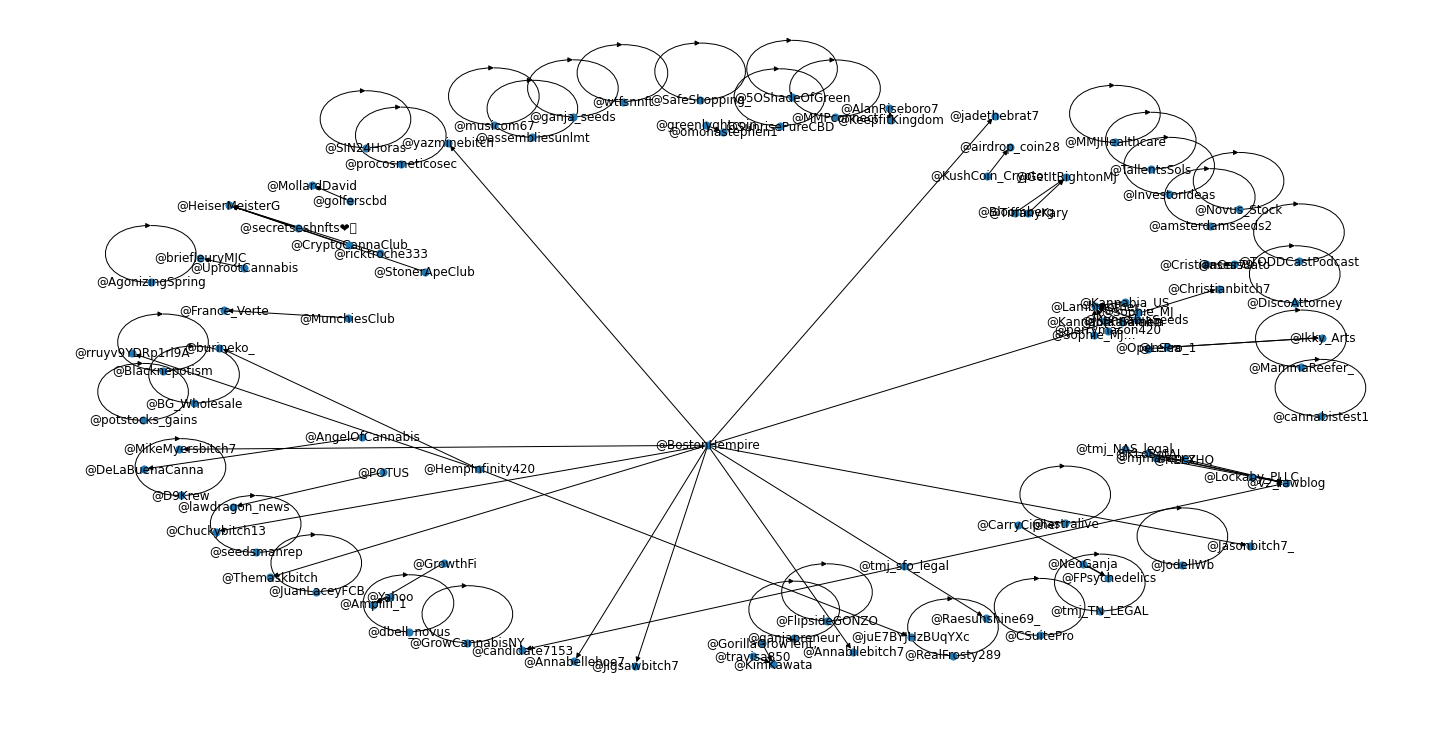

In [291]:
#draw network graph


final_copy = deepcopy(final)
final_copy_sub = final.head(100)

graph = nx.DiGraph()  
graph.add_edges_from(final_copy_sub['nodes'])


plt.figure(figsize = (20, 10))

nx.draw(graph, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

In [295]:
politicians = pd.read_csv('dataset.csv')
ls1 = final['User_A'] 
ls2 = final['User_B']
a1 = set(ls1)
a2 = set(ls2)
b = set(['@'+x for x in politicians['Twitter_username']])
#print(a1.intersection(b))
politicians_ls = list(a1.intersection(b))
politicians_ls

['@tedcruz',
 '@SpeakerPelosi',
 '@CoryBooker',
 '@POTUS',
 '@SenSchumer',
 '@BernieSanders',
 '@GovMurphy',
 '@JoeBiden',
 '@KamalaHarris']

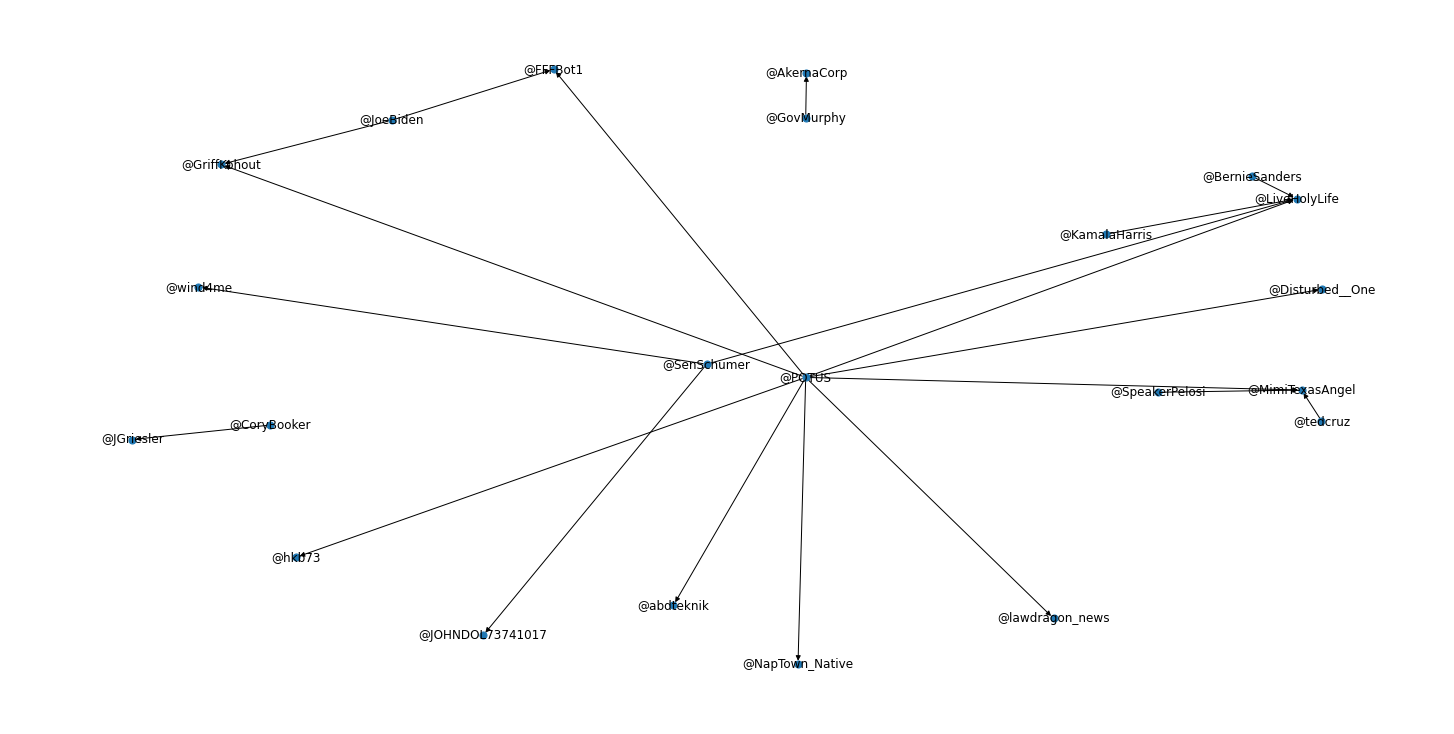

In [296]:
#draw network graph
final_copy = deepcopy(final)
final_copy_sub = final_copy[final_copy['User_A'].isin(politicians_ls)]

graph = nx.DiGraph()  
graph.add_edges_from(final_copy_sub['nodes'])


plt.figure(figsize = (20, 10))

nx.draw(graph, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8297 (\N{POP DIRECTIONAL ISOLATE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


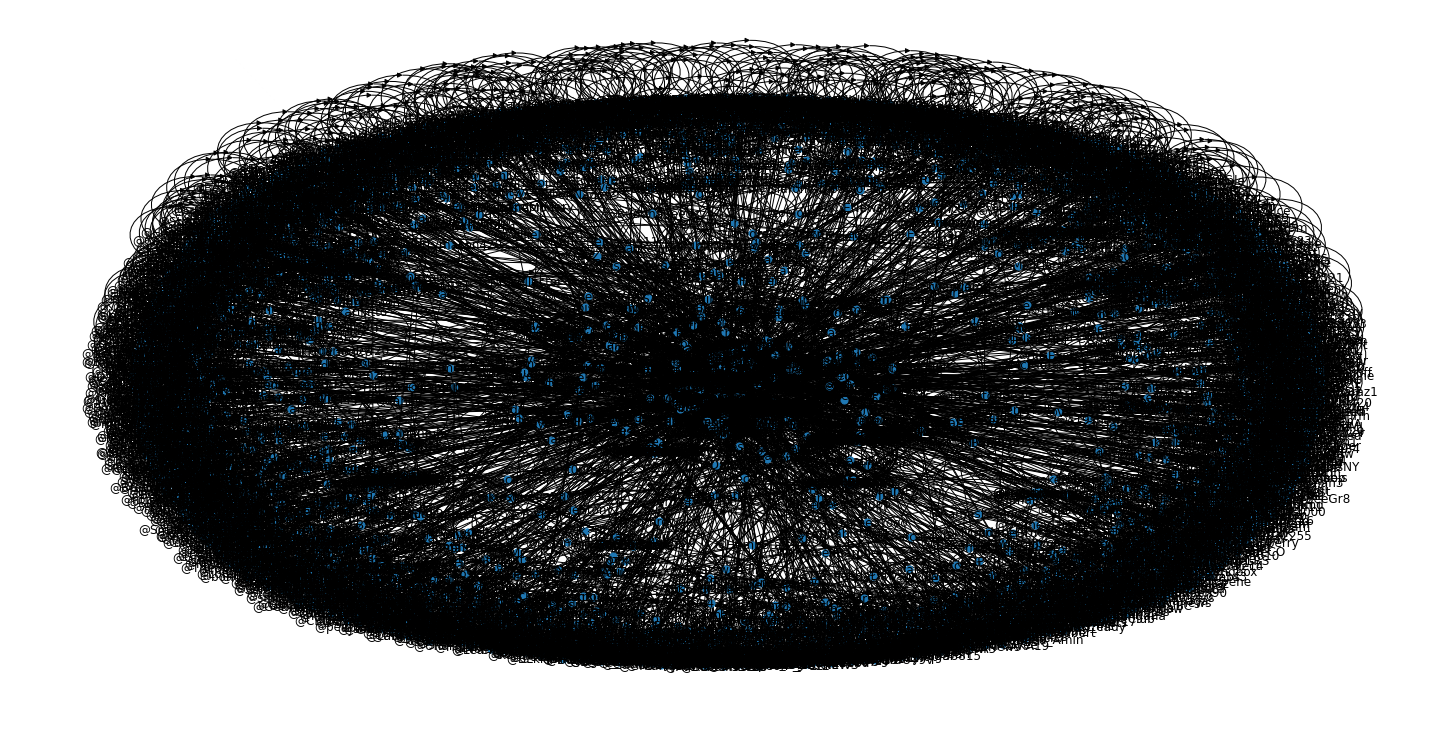

In [97]:
#draw network graph

graph = nx.DiGraph()  
graph.add_edges_from(final['nodes'])


plt.figure(figsize = (20, 10))

nx.draw(graph, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

In [19]:
degree = nx.degree_centrality(graph)
between = nx.betweenness_centrality(graph)
close = nx.closeness_centrality(graph)

In [20]:
network_df = pd.DataFrame([degree, between,close]).T
network_df.columns = ['degree', 'betweeness', 'closeness']

In [21]:
network_df = network_df.reset_index()

network_df.rename(columns = {'index':'Username'}, inplace = True)

In [22]:
tweets = pd.read_csv('marijuana.csv')
tweets.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers
0,0,Medical #cannabis sales in #Arkansas surpassed...,1,0,2022-02-25 22:01:52+00:00,ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643
1,1,RT @KeepfitKingdom: NO SLEEP? Then CBD or Krat...,0,1,2022-02-25 22:01:11+00:00,AlanRiseboro7,139,NaN,241,23
2,2,What are 1-4 issues you want to fix in South D...,0,0,2022-02-25 22:01:07+00:00,JodellWb,46712,Dog lover,1458,327
3,3,RT @LePro_1: ☮️ Make Art Not War! ☮️🕊️🌿\n\nCry...,0,33,2022-02-25 22:01:01+00:00,Ikky_Arts,5929,🚀 Fractal Multiverse Collection\n👉 100 Unique ...,1313,1591
4,4,The Pennsylvania Department of Agriculture is ...,0,0,2022-02-25 22:00:59+00:00,JuanLaceyFCB,0,Farms Close By - CEO,3,2


In [23]:
tweets['Username'] = tweets.apply(add_a, axis = 1)

In [24]:
tweets = tweets.merge(network_df, on = 'Username')
tweets.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers,degree,betweeness,closeness
0,0,Medical #cannabis sales in #Arkansas surpassed...,1,0,2022-02-25 22:01:52+00:00,@ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643,0.019231,0.0,0.000000
1,1506,A recent #NewMexico Supreme Court ruling confi...,4,2,2022-02-25 18:44:37+00:00,@ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643,0.019231,0.0,0.000000
2,2123,#NewJersey Gov. Phil Murphy (D) recently indic...,8,3,2022-02-25 17:38:42+00:00,@ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643,0.019231,0.0,0.000000
3,2684,A #California proposal is seeking to suspend t...,3,1,2022-02-25 16:36:13+00:00,@ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643,0.019231,0.0,0.000000
4,1,RT @KeepfitKingdom: NO SLEEP? Then CBD or Krat...,0,1,2022-02-25 22:01:11+00:00,@AlanRiseboro7,139,NaN,241,23,0.009615,0.0,0.009615


In [25]:
tweets.rename(columns = {'Following':'A_following_count', 'Followers': 'A_follower_count'}, inplace = True)

In [26]:
#create dataframe with information from User_B

for_b = pd.read_csv('marijuana.csv')

for_b['Username'] = for_b.apply(add_a, axis = 1)
for_b['User_B'] = for_b.apply(find_b, axis = 1)
for_b['User_B'] = for_b.apply(lambda x: x['User_B'][0], axis = 1)
for_b.rename(columns = {'Username':'User_A'}, inplace = True)
for_b['Type'] = for_b.apply(extract_type, axis = 1)
for_b = for_b.merge(network_df, left_on = 'User_B', right_on = 'Username')
for_b.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,User_A,Likes,User Description,Following,Followers,User_B,Type,Username,degree,betweeness,closeness
0,0,Medical #cannabis sales in #Arkansas surpassed...,1,0,2022-02-25 22:01:52+00:00,@ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643,@ganjapreneur,Tweet,@ganjapreneur,0.019231,0.0,0.0
1,1383,RT @ganjapreneur: A recent #NewMexico Supreme ...,0,2,2022-02-25 19:01:14+00:00,@rootwurks,7,We make compliance and education tools for can...,422,38,@ganjapreneur,Retweet,@ganjapreneur,0.019231,0.0,0.0
2,1501,RT @ganjapreneur: A recent #NewMexico Supreme ...,0,2,2022-02-25 18:45:25+00:00,@REGULATEDpod,5927,Legal and business news podcast from former re...,3164,636,@ganjapreneur,Retweet,@ganjapreneur,0.019231,0.0,0.0
3,1506,A recent #NewMexico Supreme Court ruling confi...,4,2,2022-02-25 18:44:37+00:00,@ganjapreneur,11388,Ganjapreneur is the industry leader in cannabi...,2780,38643,@ganjapreneur,Tweet,@ganjapreneur,0.019231,0.0,0.0
4,1742,RT @ganjapreneur: #NewJersey Gov. Phil Murphy ...,0,3,2022-02-25 18:18:18+00:00,@REGULATEDpod,5927,Legal and business news podcast from former re...,3164,636,@ganjapreneur,Retweet,@ganjapreneur,0.019231,0.0,0.0


In [27]:
#add user_b 
tweets_merged_b = tweets.merge(for_b, left_index = True, right_index = True, suffixes = ('_a', '_b'))

tweets_merged_b = tweets_merged_b[['User_A', 'Likes_a', 'A_follower_count', 'A_following_count', 
                                   'Tweet Favorite Count_a', 'User_B', 'Type',
                                   'degree_a', 'betweeness_a', 'closeness_a',
                                   'degree_b', 'betweeness_b', 'closeness_b']]

tweets_merged_b.head()

,User_A,Likes_a,A_follower_count,A_following_count,Tweet Favorite Count_a,User_B,Type,degree_a,betweeness_a,closeness_a,degree_b,betweeness_b,closeness_b
0,@ganjapreneur,11388,38643,2780,1,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
1,@rootwurks,11388,38643,2780,4,@ganjapreneur,Retweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
2,@REGULATEDpod,11388,38643,2780,8,@ganjapreneur,Retweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
3,@ganjapreneur,11388,38643,2780,3,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
4,@REGULATEDpod,139,23,241,0,@ganjapreneur,Retweet,0.009615,0.0,0.009615,0.019231,0.0,0.0


In [28]:
#merge to match user a and user b

tweets_merged = tweets_merged_b.merge(tweets_merged_b, left_on = 'User_B', right_on = 'User_A', how = 'left')

tweets_merged = tweets_merged.drop_duplicates(
  subset = ['User_A_x', 'User_B_x'],
  keep = 'last').reset_index(drop = True).dropna()
tweets_merged.rename(columns = {'User_A_x':'User_A','User_B_x':'User_B', 'Type_x':'Type', 'A_follower_count_x':
                                'A_follower_count','A_following_count_x':'A_following_count','A_follower_count_y':'B_follower_count',
                                'A_following_count_y':'B_following_count', 'degree_a_x':'A_network_feature_1',
                                'closeness_a_x' :'A_network_feature_2', 'betweeness_a_x': 'A_network_feature_3',
                                'degree_b_x':'B_network_feature_1',
                                'closeness_b_x': 'B_network_feature_2', 'betweeness_b_x': 'B_network_feature_3'}, inplace = True)
tweets_merged.iloc[0:25]

,User_A,Likes_a_x,A_follower_count,A_following_count,Tweet Favorite Count_a_x,User_B,Type,A_network_feature_1,A_network_feature_3,A_network_feature_2,...,B_following_count,Tweet Favorite Count_a_y,User_B_y,Type_y,degree_a_y,betweeness_a_y,closeness_a_y,degree_b_y,betweeness_b_y,closeness_b_y
0,@rootwurks,11388,38643,2780,4,@ganjapreneur,Retweet,0.019231,0.0,0.000000,...,1460.0,0.0,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
1,@HighGroundCann,46712,327,1458,0,@ganjapreneur,Retweet,0.019231,0.0,0.000000,...,1460.0,0.0,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
2,@10000Bakes,46712,327,1458,0,@ganjapreneur,Retweet,0.019231,0.0,0.000000,...,1460.0,0.0,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
3,@REGULATEDpod,46717,327,1460,1,@ganjapreneur,Retweet,0.019231,0.0,0.000000,...,1460.0,0.0,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
4,@ganjapreneur,46717,327,1460,0,@ganjapreneur,Tweet,0.019231,0.0,0.000000,...,1460.0,0.0,@ganjapreneur,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
6,@JodellWb,0,2,3,0,@JodellWb,Tweet,0.019231,0.0,0.000000,...,3.0,0.0,@JodellWb,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
43,@JuanLaceyFCB,155,701,688,0,@JuanLaceyFCB,Tweet,0.019231,0.0,0.000000,...,688.0,0.0,@JuanLaceyFCB,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
44,@TallentsSols,155,701,688,0,@TallentsSols,Tweet,0.019231,0.0,0.000000,...,688.0,0.0,@TallentsSols,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
45,@tmj_TN_LEGAL,155,701,688,0,@tmj_TN_LEGAL,Tweet,0.019231,0.0,0.000000,...,688.0,0.0,@tmj_TN_LEGAL,Tweet,0.019231,0.0,0.000000,0.019231,0.0,0.0
47,@worldcannanews1,1335,8342,5478,0,@ganja_seeds,Retweet,0.019231,0.0,0.000000,...,3.0,0.0,@ganja_seeds,Tweet,0.009615,0.0,0.009615,0.019231,0.0,0.0


In [29]:
#find mentions received and sent for each user

mentions_received = {}
mentions_sent = {}

count = 0

for tup in tweets_merged.iterrows():
    row = tup[1]
    kind = row['Type']
    if kind == 'Mention':
        b = row['User_B']
        a = row['User_A']
        if b in mentions_received:
            mentions_received[b] += 1
        else:
            mentions_received[b] = 1
        if a in mentions_sent:
            mentions_sent[a] += 1
        else:
            mentions_sent[a] = 1

In [30]:
tweets_merged['A_mentions_received'] = tweets_merged['User_A'].map(mentions_received)
tweets_merged['A_mentions_sent'] = tweets_merged['User_A'].map(mentions_sent)
tweets_merged['B_mentions_received'] = tweets_merged['User_B'].map(mentions_received)
tweets_merged['B_mentions_sent'] = tweets_merged['User_B'].map(mentions_sent)
tweets_merged.fillna(0, inplace=True)
tweets_merged.head()

,User_A,Likes_a_x,A_follower_count,A_following_count,Tweet Favorite Count_a_x,User_B,Type,A_network_feature_1,A_network_feature_3,A_network_feature_2,...,degree_a_y,betweeness_a_y,closeness_a_y,degree_b_y,betweeness_b_y,closeness_b_y,A_mentions_received,A_mentions_sent,B_mentions_received,B_mentions_sent
0,@rootwurks,11388,38643,2780,4,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.019231,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0
1,@HighGroundCann,46712,327,1458,0,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.019231,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0
2,@10000Bakes,46712,327,1458,0,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.019231,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0
3,@REGULATEDpod,46717,327,1460,1,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.019231,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0
4,@ganjapreneur,46717,327,1460,0,@ganjapreneur,Tweet,0.019231,0.0,0.0,...,0.019231,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#find retweets received and sent for each user

retweets_received = {}
retweets_sent = {}

count = 0

for tup in tweets_merged.iterrows():
    row = tup[1]
    kind = row['Type']
    if kind == 'Retweet':
        b = row['User_B']
        a = row['User_A']
        if b in retweets_received:
            retweets_received[b] += 1
        else:
            retweets_received[b] = 1
        if a in retweets_sent:
            retweets_sent[a] += 1
        else:
              retweets_sent[a] = 1

In [32]:
tweets_merged['A_retweets_received'] = tweets_merged['User_A'].map(retweets_received)
tweets_merged['B_retweets_received'] = tweets_merged['User_B'].map(retweets_received)
tweets_merged['A_retweets_sent'] = tweets_merged['User_A'].map(retweets_sent)
tweets_merged['B_retweets_sent'] = tweets_merged['User_B'].map(retweets_sent)
tweets_merged.fillna(0, inplace=True)
tweets_merged.head()

,User_A,Likes_a_x,A_follower_count,A_following_count,Tweet Favorite Count_a_x,User_B,Type,A_network_feature_1,A_network_feature_3,A_network_feature_2,...,betweeness_b_y,closeness_b_y,A_mentions_received,A_mentions_sent,B_mentions_received,B_mentions_sent,A_retweets_received,B_retweets_received,A_retweets_sent,B_retweets_sent
0,@rootwurks,11388,38643,2780,4,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0
1,@HighGroundCann,46712,327,1458,0,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0
2,@10000Bakes,46712,327,1458,0,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0
3,@REGULATEDpod,46717,327,1460,1,@ganjapreneur,Retweet,0.019231,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0
4,@ganjapreneur,46717,327,1460,0,@ganjapreneur,Tweet,0.019231,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0


In [33]:
User_A = tweets_merged.User_A
User_B = tweets_merged.User_B

In [34]:
tweets_merged_num = tweets_merged[['A_follower_count','A_following_count','A_mentions_received', 'A_mentions_sent',
                                   'A_retweets_received', 'A_retweets_sent','B_mentions_sent','B_follower_count','B_following_count',
                                   'B_mentions_received','B_retweets_received','B_retweets_sent',
                                   'A_network_feature_1', 'A_network_feature_2', 'A_network_feature_3',
                                   'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3']]
tweets_merged_num = (tweets_merged_num - tweets_merged_num.mean())/tweets_merged_num.std()
tweets_merged_num.head()

,A_follower_count,A_following_count,A_mentions_received,A_mentions_sent,A_retweets_received,A_retweets_sent,B_mentions_sent,B_follower_count,B_following_count,B_mentions_received,B_retweets_received,B_retweets_sent,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0.203744,-0.308086,-0.069338,-0.069338,-0.115972,0.357603,NaN,-0.129408,-0.226311,-0.959935,-1.144467,NaN,0.232959,-0.364527,NaN,1.898633,NaN,NaN
1,-0.168647,-0.451033,-0.069338,-0.069338,-0.115972,0.357603,NaN,-0.129408,-0.226311,-0.959935,-1.144467,NaN,0.232959,-0.364527,NaN,1.898633,NaN,NaN
2,-0.168647,-0.451033,-0.069338,-0.069338,-0.115972,0.357603,NaN,-0.129408,-0.226311,-0.959935,-1.144467,NaN,0.232959,-0.364527,NaN,1.898633,NaN,NaN
3,-0.168647,-0.450817,-0.069338,-0.069338,-0.115972,0.357603,NaN,-0.129408,-0.226311,-0.959935,-1.144467,NaN,0.232959,-0.364527,NaN,1.898633,NaN,NaN
4,-0.168647,-0.450817,-0.069338,-0.069338,0.438562,-2.121780,NaN,-0.129408,-0.226311,-0.959935,-1.144467,NaN,0.232959,-0.364527,NaN,1.898633,NaN,NaN


## Use Training Set to Determine Important coefficients

In [35]:
train = pd.read_csv('train.csv')

In [36]:
#normalize training data for modeling

x= train.drop(['Choice'], axis = 1)
y = train['Choice']
normalized_x=(x-x.mean())/x.std()
normalized_x.head()

,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,-0.320219,-0.252138,-0.343123,-0.091391,-0.094229,-0.620955,-0.528464,-0.476683,-0.181912,0.784974,...,0.341023,-0.258561,-0.101207,-0.106312,0.216318,-0.398890,-0.129578,-0.193770,-0.088986,-0.331306
1,-0.309689,-0.234243,-0.330146,-0.088309,-0.091883,-0.031780,0.000646,-0.213757,-0.169234,-0.637650,...,-0.237546,-0.263408,-0.100208,-0.105781,-0.295181,-0.279339,-0.434267,-0.190148,0.440592,-0.147445
2,-0.316728,-0.233509,-0.337471,-0.090536,-0.093366,-0.068316,-0.271566,-0.300420,-0.178699,-0.152560,...,-0.244858,-0.349551,-0.101793,-0.106700,-0.564923,-0.518442,-0.458315,-0.196123,-0.700078,-0.628414
3,-0.320321,-0.258157,-0.343180,-0.091147,-0.094213,-0.491645,-0.528464,-0.341876,-0.181774,-0.795644,...,0.097868,-0.345134,-0.078989,-0.064960,2.204867,3.124530,1.163267,-0.130436,-0.576954,-0.425727
4,-0.297860,-0.240711,-0.190981,-0.086307,-0.090861,2.297307,1.164108,0.806646,-0.162946,0.409318,...,-0.220305,-0.351085,-0.100962,-0.106355,0.068348,0.006954,-0.254448,-0.193061,-0.342341,-0.317401


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

x_train, x_test, y_train, y_test = train_test_split(normalized_x, y, test_size=0.2, random_state=42)
logreg = LogisticRegression(max_iter=2000).fit(x_train, y_train)
pred = logreg.predict(x_test)
accur = accuracy_score(y_test, pred)
print('Accuracy of logistic regression full data: ' + str(accur))

Accuracy of logistic regression full data: 0.7363636363636363


In [38]:
coefs = logreg.coef_
coefs

array([[-0.15446118,  0.12203766,  1.58186354, -0.30305643, -1.00455661,
         0.06978219,  0.20002531,  0.06486033,  0.82181044,  0.1535141 ,
         0.13675315,  0.2736112 , -0.01399382, -1.82262169,  0.05963645,
         0.55471399, -0.13684304, -0.29567055,  0.04114868, -0.54679358,
        -0.07890551, -0.16003573]])

In [39]:
#Stats model for p-values with all data
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.567325
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Choice   No. Observations:                 4400
Model:                          Logit   Df Residuals:                     4378
Method:                           MLE   Df Model:                           21
Date:                Sat, 26 Feb 2022   Pseudo R-squ.:                  0.1814
Time:                        19:26:27   Log-Likelihood:                -2496.2
converged:                       True   LL-Null:                       -3049.4
Covariance Type:            nonrobust   LLR p-value:                6.003e-221
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
A_follower_count       -0.1843      0.101     -1.832      0.067      -0.381       0.013
A_

In [40]:
coefs = pd.DataFrame(result.params)
important_coef = coefs.drop(['A_follower_count','A_mentions_received', 'A_mentions_sent', 'A_posts', 'B_following_count', 'B_mentions_received','B_retweets_received','B_posts', 'B_network_feature_2'])

In [41]:
important_coef

,0
A_following_count,0.121584
A_listed_count,1.644344
A_retweets_received,-1.129121
A_retweets_sent,0.197901
A_network_feature_1,0.876812
A_network_feature_2,0.152523
A_network_feature_3,0.138765
B_follower_count,0.304979
B_listed_count,-1.861043
B_mentions_sent,-0.137796


In [ ]:
## Calculate Influencer Score
df_final['Score'] = 